In [ ]:
!pip install torch==1.9.0+cu102 -f https://download.pytorch.org/whl/torch_stable.html
!pip install albumentations==0.5.0

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [ ]:
import torch
from torch.nn import Module,ModuleList,Conv2d,BatchNorm2d,ReLU,Sequential,ConvTranspose2d,Sigmoid,L1Loss
import torchvision.models as models
import torch.nn.functional as F
import cv2
import numpy as np
import os
from torch.optim import Adam
from torch.utils.data import DataLoader
from tqdm import tqdm
import zipfile



In [ ]:
url='/content/drive/MyDrive/Digest/segementationdata.zip'
with zipfile.ZipFile(url) as zf:
       for member in tqdm(zf.infolist(), desc='Extracting '):
             zf.extract(member, './')

Extracting : 100%|██████████| 67101/67101 [09:14<00:00, 121.03it/s] 


In [ ]:
loss=L1Loss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.randn(3, 5)
output = loss(input, target)
print(input,target,output)

tensor([[-0.9853,  0.3440, -0.5163,  0.8446,  0.5877],
        [ 0.1217, -1.1177, -0.9419, -0.8050,  2.5108],
        [-0.9353, -0.1885, -0.7018, -0.6034, -1.1475]], requires_grad=True) tensor([[ 0.8572,  0.3286, -1.0079,  0.0179, -0.1133],
        [-1.4012, -1.3621, -1.0398, -0.2524,  0.8743],
        [-0.7426, -0.2109, -2.0715, -0.2471,  0.8724]]) tensor(0.7928, grad_fn=<L1LossBackward>)


In [ ]:
print(torch.mean(torch.abs(input - target)))

tensor(0.7928, grad_fn=<MeanBackward0>)


In [ ]:

class Convolutional_Block(Module):
  def __init__(self,indim,outdim,kernel,pad=0):

    super().__init__()

    self.conv = Conv2d(in_channels=indim, out_channels=outdim, kernel_size=kernel,padding=pad)
    self.bn = BatchNorm2d(outdim)
    self.relu = ReLU()

  def forward(self, x):
     x = self.conv(x)
     x = self.bn(x)
     x = self.relu(x)
     return x

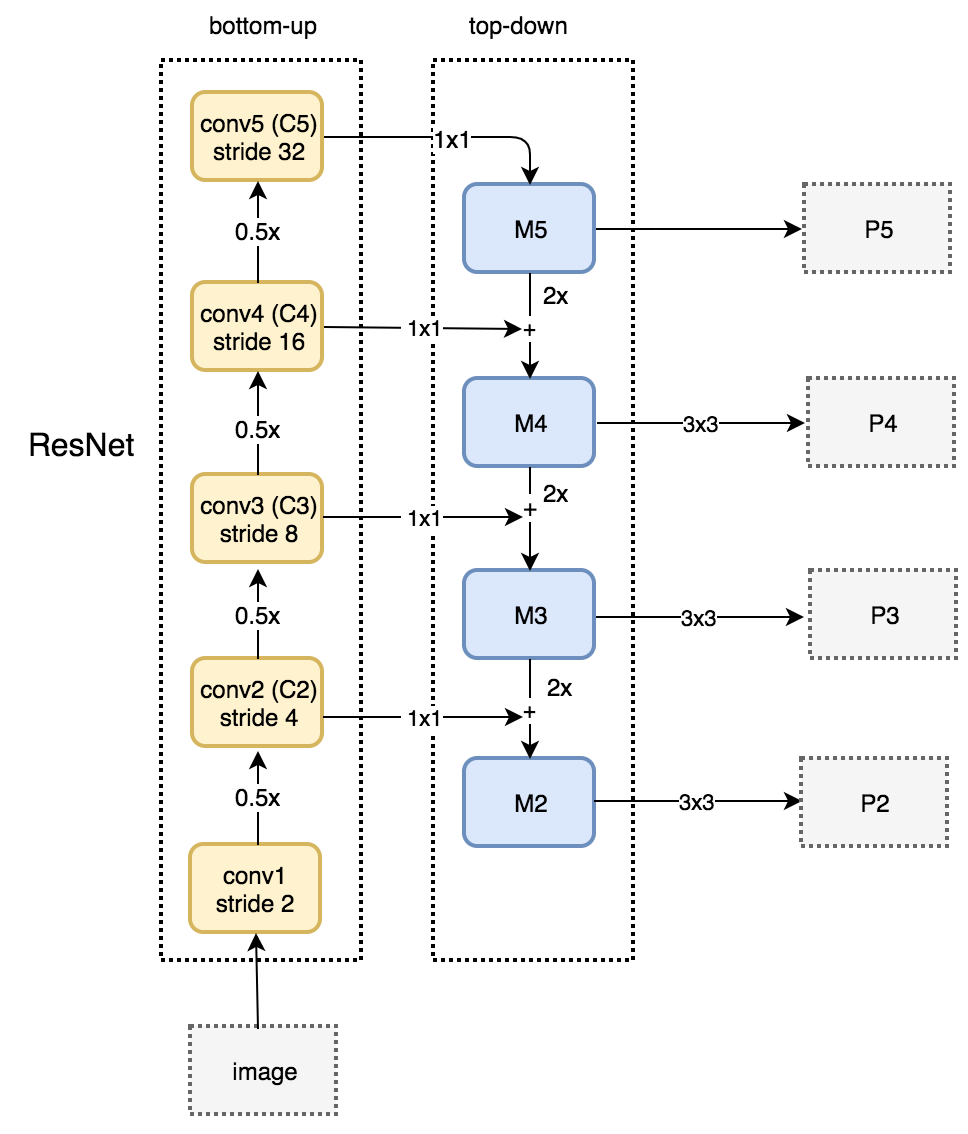

In [ ]:
    
class Feature_Pyramid_Network(Module):
  def __init__(self,fpn_dim=256):
        super().__init__()
        features=[64,128,256,512]
        # 1x1 for converting all level feature to same dimension for adding
        # 3x3 for smoothening after merging two features

        self.pyr2=Convolutional_Block(features[0],fpn_dim,1)
        self.pyr2_m=Convolutional_Block(fpn_dim,fpn_dim,3,1)# pad 1 so kernel 3 will not change (h,w) dimension of feature

        self.pyr3=Convolutional_Block(features[1],fpn_dim,1)
        self.pyr3_m=Convolutional_Block(fpn_dim,fpn_dim,3,1)

        self.pyr4=Convolutional_Block(features[2],fpn_dim,1)
        self.pyr4_m=Convolutional_Block(fpn_dim,fpn_dim,3,1)

        self.pyr5=Convolutional_Block(features[3],fpn_dim,1)
        self.pyr5_m=Convolutional_Block(fpn_dim,fpn_dim,3,1)

        self.fpnconv=Convolutional_Block(fpn_dim*4,fpn_dim,3,1)

  def forward(self,features):

        x2,x3,x4,x5=features   
        P5=self.pyr5(x5)
        P5=self.pyr5_m(P5)
        temp=F.interpolate(P5,size=x4.shape[2:])

        P4=self.pyr4(x4)+temp
        P4=self.pyr4_m(P4)
        temp=F.interpolate(P4,size=x3.shape[2:])
        
        P3=self.pyr3(x3)+temp
        P3=self.pyr3_m(P3)
        temp=F.interpolate(P3,size=x2.shape[2:])
        
        P2=self.pyr2(x2)+temp
        P2=self.pyr2_m(P2)
        
        
      
        
        h,w=x2.shape[2:]
        P3 = F.interpolate(P3, size=(h, w))
        P4 = F.interpolate(P4, size=(h, w))
        P5 = F.interpolate(P5, size=(h, w))


        final= torch.cat([P2, P3, P4, P5], dim=1) # adding in features dimension

        y=self.fpnconv(final)

        return y


In [ ]:

#“pred” consists of a 3×3 convolutional operator and two de-convolutional operators with stride 2
def DB_pred(dim):
  return  Sequential(
            Conv2d(dim, dim // 4, 3, padding=1),
            BatchNorm2d(dim // 4),
            ReLU(inplace=True),
            ConvTranspose2d(dim // 4, dim // 8, 2, 2),
            BatchNorm2d(dim // 8),
            ReLU(inplace=True),
            ConvTranspose2d(dim // 8, dim // 16, 2, 2),
            BatchNorm2d(dim // 16),
            ReLU(inplace=True),
            Conv2d(dim // 16, 1, 1,),
            Sigmoid()
            )


In [ ]:
def interpolate(op_maps,size):
  return  [F.interpolate(map, size=size) for map in op_maps]


In [ ]:
import torch.nn.functional as F


In [ ]:

class dbnet(Module):
  def __init__(self):
    super().__init__()
        
    backbone=models.resnet18(pretrained=True)
    modules = list(backbone.children())[:-2]
    self.backbone=ModuleList(modules)

    self.fpn=Feature_Pyramid_Network(256)
    self.pred_prob=DB_pred(256)
    self.pred_thresh=DB_pred(256)
    self.K=50 #paper

    self.l1=L1Loss()

  def dice(self,prediction,label):

    # dice loss
    # 2 * intersection  => 2 * (pred * label)
    # _________________
    #
    # Union + intersection ==> pred+label
    
    smooth = 1

    iflat = prediction.view(-1)
    tflat = label.view(-1)
    intersection = (iflat * tflat).sum()
    
    dice= 1 - ((2. * intersection + smooth) /
              (iflat.sum() + tflat.sum() + smooth))
   
    return dice
       
            


  def dbloss(self,prediction,groundtruth):

    probmap,threshmap,binarymap=prediction

    
    
    
    binloss=self.dice(binarymap,groundtruth)
    probloss=self.dice(probmap,groundtruth)

    threshloss=self.l1(threshmap,groundtruth)
    

    """L = Ls + α × Lb + β × Lt (7)
        where Ls is the loss for the probability map and Lb is the
        loss for the binary map. According to the numeric values of
        the losses, α and β are set to 1.0 and 10 respectively"""
        
    loss= probloss+binloss +threshloss
    """
    bindice=self.dice(prediction,groundtruth)
    #print("pred",prediction.view(-1) ,"true", groundtruth.view(-1))"""
    zz=binarymap.view(-1)
    zz=torch.where(zz >= 0.5, 1.0, 0.)
    acc= torch.mean(( zz== groundtruth.view(-1)).float())   
    return loss,acc






  def forward(self,image):

    features=[]
    x=image
    for i,layer in enumerate(self.backbone):
      x=layer(x)
      if(i in {4,5,6,7}):
        features.append(x)

    concat_enhanced_features=self.fpn(features)   
    probmap=self.pred_prob(concat_enhanced_features)
    threshmap=self.pred_thresh(concat_enhanced_features)

    binarymap=torch.div(1,1+torch.exp(-self.K*(probmap-threshmap))) # paper formula

    op=interpolate([probmap,threshmap,binarymap],image.shape[2:])

    return op

    

In [ ]:
"""
def preprocess(image):

        sh=min(image.shape[:2])
        if(sh>1024):
            rat=1024/sh
            sha=[int(i*rat) for i in image.shape[:2]]
            image=cv2.resize(image,tuple(sha[::-1]))

        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]

        image = image.astype(np.float32)
        image /= 255.
        image -= mean
        image /= std

        if(len(image.shape)==3):
            image=np.expand_dims(image,0)

        if(image.shape[-1]==3):
            image=np.transpose(image,(0,3,1,2))

        return image

def preprocess_mask(mask):
  
    if(len(mask.shape)==2):
              mask=np.expand_dims(mask,-1)

    sh=min(mask.shape[:2])

    if(sh>1024):
        rat=1024/sh
        sha=[int(i*rat) for i in mask.shape[:2]]
        mask=cv2.resize(mask,tuple(sha[::-1]))   
               
    if(len(mask.shape)==3):
              mask=np.expand_dims(mask,0)
    if(mask.shape[-1]==1):
        mask=np.transpose(mask,(0,3,1,2))


    return mask """   

def preprocess(image):

        image=cv2.resize(image,(640,640))

        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]

        image = image.astype(np.float32)
        image /= 255.
        image -= mean
        image /= std

        

        if(image.shape[-1]==3):
            image=np.transpose(image,(2,0,1))

        return image

def preprocess_mask(mask):
  
    if(len(mask.shape)==2):
              mask=np.expand_dims(mask,-1)


    mask=cv2.resize(mask,(640,640))   
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask =np.expand_dims (mask,0)          
   
    if(mask.shape[-1]==1):
        mask=np.transpose(mask,(2,0,1))


    return mask


In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
import albumentations as aug

augments= aug.Compose([
              
        aug.JpegCompression (quality_lower=0, quality_upper=100, p=1),
        aug.imgaug.transforms.IAAAdditiveGaussianNoise (loc=0, scale=(2.55000, 12.75)),  
        aug.augmentations.transforms.RandomShadow (shadow_roi=(0, 0.5, 1, 1), num_shadows_lower=1, num_shadows_upper=2, shadow_dimension=5),
        aug.RandomBrightnessContrast(p=1,brightness_limit=0.2, contrast_limit=0.2),
        
    ], p = 1)  
def augment(image,mask):
    
    augmented=augments(image=image,mask=mask)     
    return augmented["image"],augmented["mask"]

In [ ]:

class generator():
  def __init__(self,image,masks,shuffle=False):
    self.imgpth=image
    self.mskpth=masks
    self.images=os.listdir(image)
    self.masks=os.listdir(masks)

    self.shuffle=shuffle
  def __len__(self):
      return len(self.masks)
  def __getitem__(self,index):

    record=self.masks[index]

    image=cv2.imread(self.imgpth+record)
    masks=cv2.imread(self.mskpth+record)
    masks = cv2.blur(masks, (10,10))

    image,masks=augment(image,masks)
    
    _, masks = cv2.threshold(masks, 50, 255,	cv2.THRESH_BINARY)
    
    """
    cv2_imshow(image)
    cv2_imshow(masks)
    print("asdadasda")"""
    norm_img=preprocess(image)
    norm_mask=preprocess_mask(masks)/255

    return {
               "X":torch.tensor(norm_img,dtype=torch.float32),
               "mask":torch.tensor(norm_mask,dtype=torch.float32)
                            
               }   



In [ ]:
def avg(x):
  return sum(x)/len(x)
class pipeline():

    def __init__(self,model,processing_unit):
        
     self.device = torch.device(processing_unit)
     self.model=model
     self.model.to(self.device)
    
    def set_optimizer(self,optimizer,lr=0.000001):
     if(optimizer=='Adam'):
      self.optim = Adam(self.model.parameters(), lr=lr)

    def fit(self,data_generator,epochs,batch_size,save_best=False):
     self.generator= data_generator
     train_data_loader = DataLoader(data_generator, batch_size=batch_size,shuffle=True, num_workers=4)
     best_acc = 0
     for epoch in range(epochs):
                 
                 final_loss=0
                 final_acc=0
                 checkloss=[]
                 checkacc=[]
                 t=tqdm(train_data_loader,total=len(train_data_loader))
                 
                 for data in t:
                       for key,value in data.items():
                             data[key]=value.to(self.device)
                       self.optim.zero_grad()
                       inp,target=data['X'],data['mask']
                       op=self.model(inp)
                       
                       loss,acc=self.model.dbloss(op,target)
                       #acc=self.model.accuracy(op,target)
           
                       
                       loss.backward()
                       self.optim.step()
                       checkloss.append(loss.item() )
                       checkacc.append(acc.item())    
                       string="epoch  "+str(epoch)+"   loss: {:.4f}".format(avg(checkloss))+"   accuracy: {:.4f}".format(avg(checkacc))  
                       t.set_description(string)
                       t.refresh() 
                       final_loss+=loss.item() 
                       final_acc+=acc.item()       
                           
                                
                                
                
              




                 print("epoch :  ",epoch,"loss :  ",final_loss/len(train_data_loader),"  accuracy :  ",final_acc/len(train_data_loader))
                 if final_acc > best_acc:
                   if(save_best):
                           torch.save(self.model.state_dict(),save_best)
                   best_acc = final_acc
    def evaluate(self,data_generator,batch_size):
     self.generator= data_generator
     eval_data_loader = DataLoader(data_generator, batch_size=batch_size,shuffle=True, num_workers=4)
                 
     final_loss=0
     final_acc=0
     checkloss=[]
     checkacc=[]
     t=tqdm(eval_data_loader,total=len(eval_data_loader))
     self.model.eval()
     for data in t:
          for key,value in data.items():
                data[key]=value.to(self.device)
          inp,target=data['X'],data['mask']
          with torch.no_grad():
            op=self.model(inp)
          
          loss,acc=self.model.dbloss(op,target)
          checkloss.append(loss.item() )
          checkacc.append(acc.item())    
          string="evaluating  "+"   loss: {:.4f}".format(avg(checkloss))+"   accuracy: {:.4f}".format(avg(checkacc))  
          t.set_description(string)
          t.refresh() 
          final_loss+=loss.item() 
          final_acc+=acc.item()   
          del loss
          del acc       
                  
  





     print("loss :  ",final_loss/len(eval_data_loader),"  accuracy :  ",final_acc/len(eval_data_loader))
    


In [ ]:

if __name__ == '__main__':    

    component=dbnet()
    pth="/content/segementationdata"
    #component.load_state_dict(torch.load("/content/drive/MyDrive/Digest/detection.pth"))  
    component.load_state_dict(torch.load("/content/drive/MyDrive/Digest/test2.pth"))  

    train=generator(pth+'/train/image/',pth+'/train/mask/')
    val=generator(pth+'/validate/image/',pth+'/validate/mask/')
    
    
    model=pipeline(component, "cuda")
    model.set_optimizer('Adam')
    #model.fit(train,100,18,"/content/drive/MyDrive/Digest/test1.pth")


In [ ]:
model.evaluate(val,20)


  0%|          | 0/194 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
evaluating     loss: 0.4020   accuracy: 0.9743: 100%|██████████| 194/194 [05:31<00:00,  1.71s/it]

loss :   0.4020238779869276   accuracy :   0.9743286054773429


In [ ]:
!nvidia-smi

Wed Sep 15 06:46:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P0    44W / 250W |  12693MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

17 58
15 51
15 52
17 58
19 65
17 58
21 70
16 56
17 58
20 67
17 58
13 45


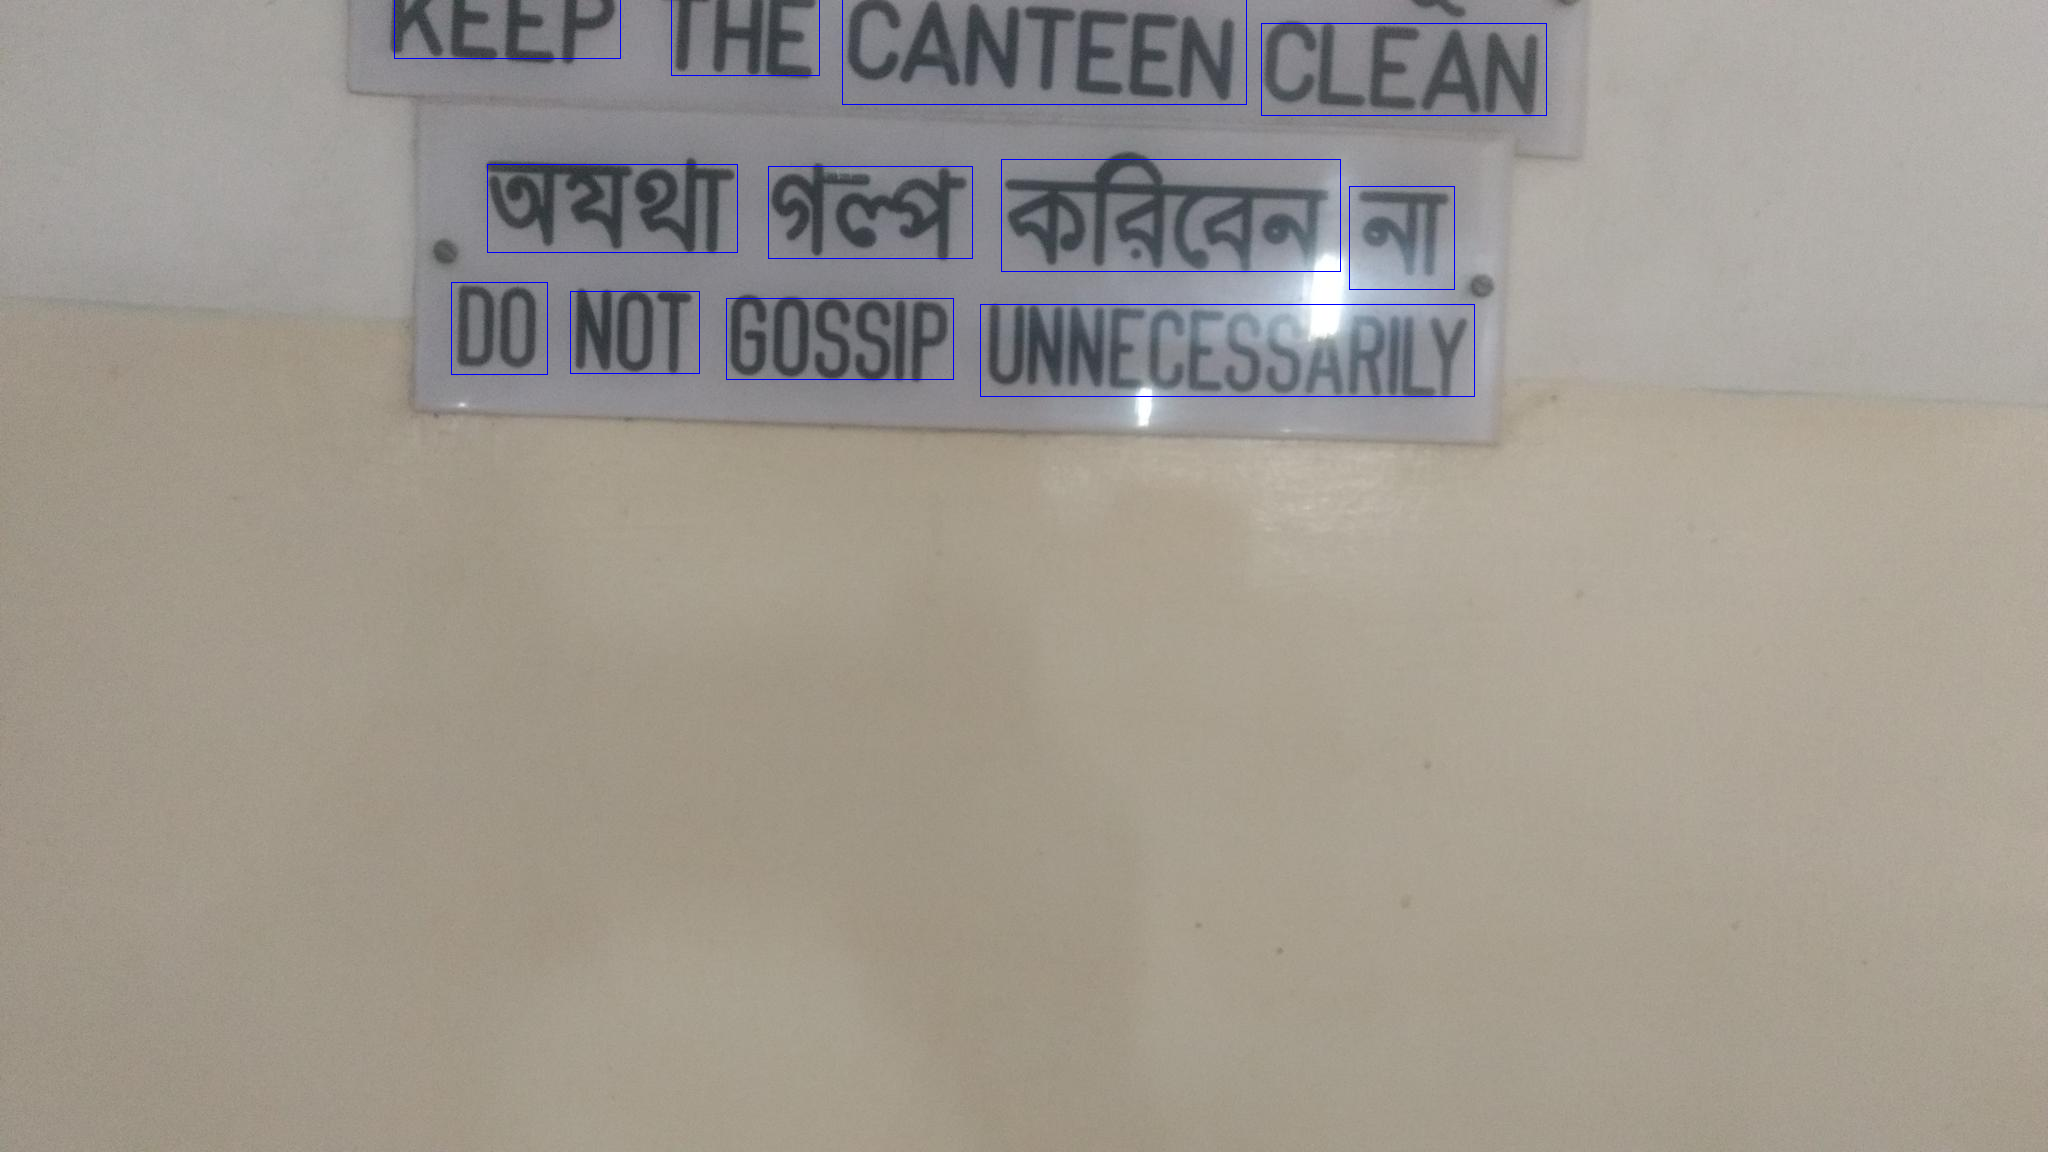

1 17
2 23
2 20
2 20
2 24
3 32
2 22
1 12
0 6
0 8
0 6
0 8
1 10
2 28
1 14
2 21
1 15
1 17
2 26
2 20
2 22
2 27
2 21
2 21
2 21
2 23
2 24
2 23
2 21
2 22
2 22
13 46
2 22
2 22
2 23
2 22
2 21
2 22
2 25
2 21
1 12
2 23
1 17
14 47
2 23
0 8
21 70
1 11
1 12
2 28
2 20
2 22
3 31
3 32
3 30
2 25
2 21
3 35
2 22
2 25
2 23
2 23
2 28
2 21
1 19
2 21
1 16
2 24
1 19
2 24
3 32
2 23
2 23
2 23
2 26
2 23
1 18
2 22
2 21
2 21
2 26
2 29
2 20
2 21
2 23
2 25
2 23
2 22
2 21
2 22
2 22
2 25
2 21
2 28
2 25
1 19
2 27
2 28
2 24
2 20
2 24
2 24
2 26
2 23
2 22
2 23
2 23
2 27
2 23
2 22
2 22
2 22
2 23
2 21
2 21
2 24
2 24
2 23
2 24
2 22
2 22
2 28
2 24
2 22
2 22
2 24
2 22
2 25
2 23
2 24
2 22
2 26
2 22
2 24
2 22
2 21
2 26
2 23
2 24
2 25
2 22
2 22
2 26
2 23
2 24
2 23
2 22
2 22
2 22
2 23
2 26
2 24
2 27
2 23
1 19
2 24
2 22
2 22
2 24
2 26
2 24
2 23
2 24
2 22
2 25
2 21
2 23
2 22
2 24
2 25
2 21
2 23
2 21
2 23
2 24
2 26
2 22
2 26
2 22
2 23
2 20
2 23
2 25
2 22
2 21
2 22
1 17
2 23
2 21
2 22
2 24
2 23
2 24
2 20
2 20
2 22
2 23
2 22
2 23
2 22
2 

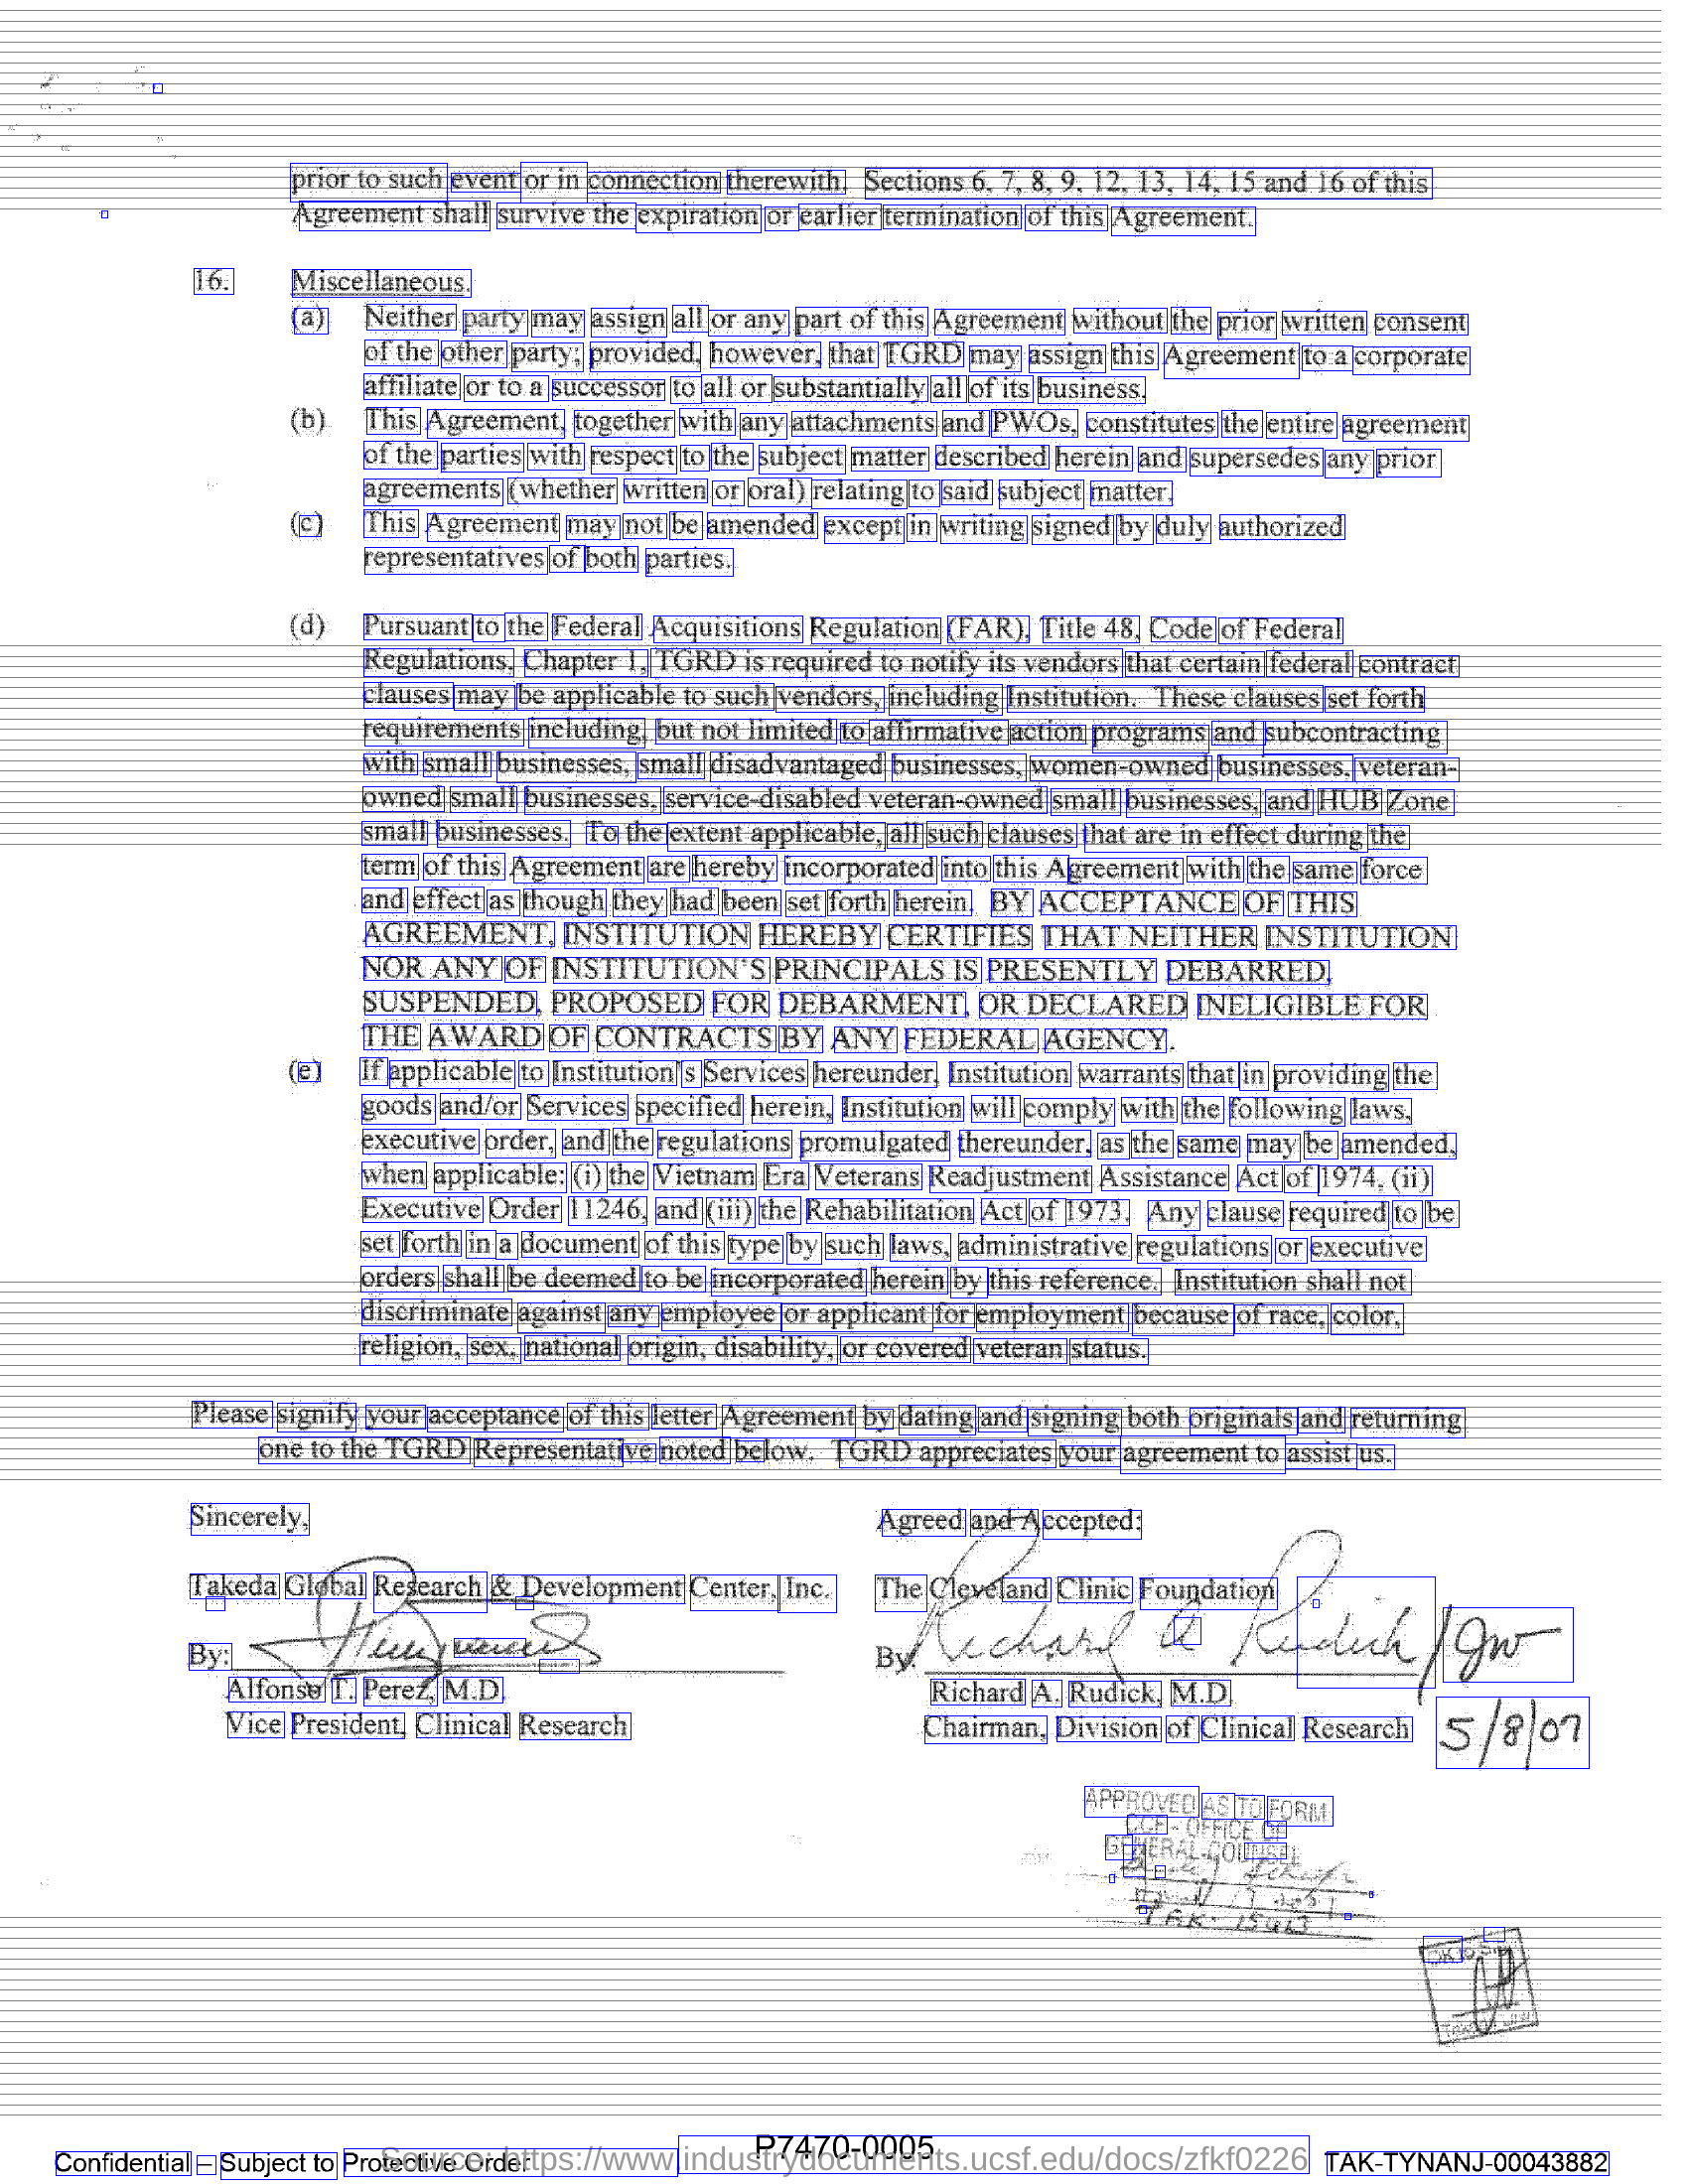

28 94
15 52
18 63


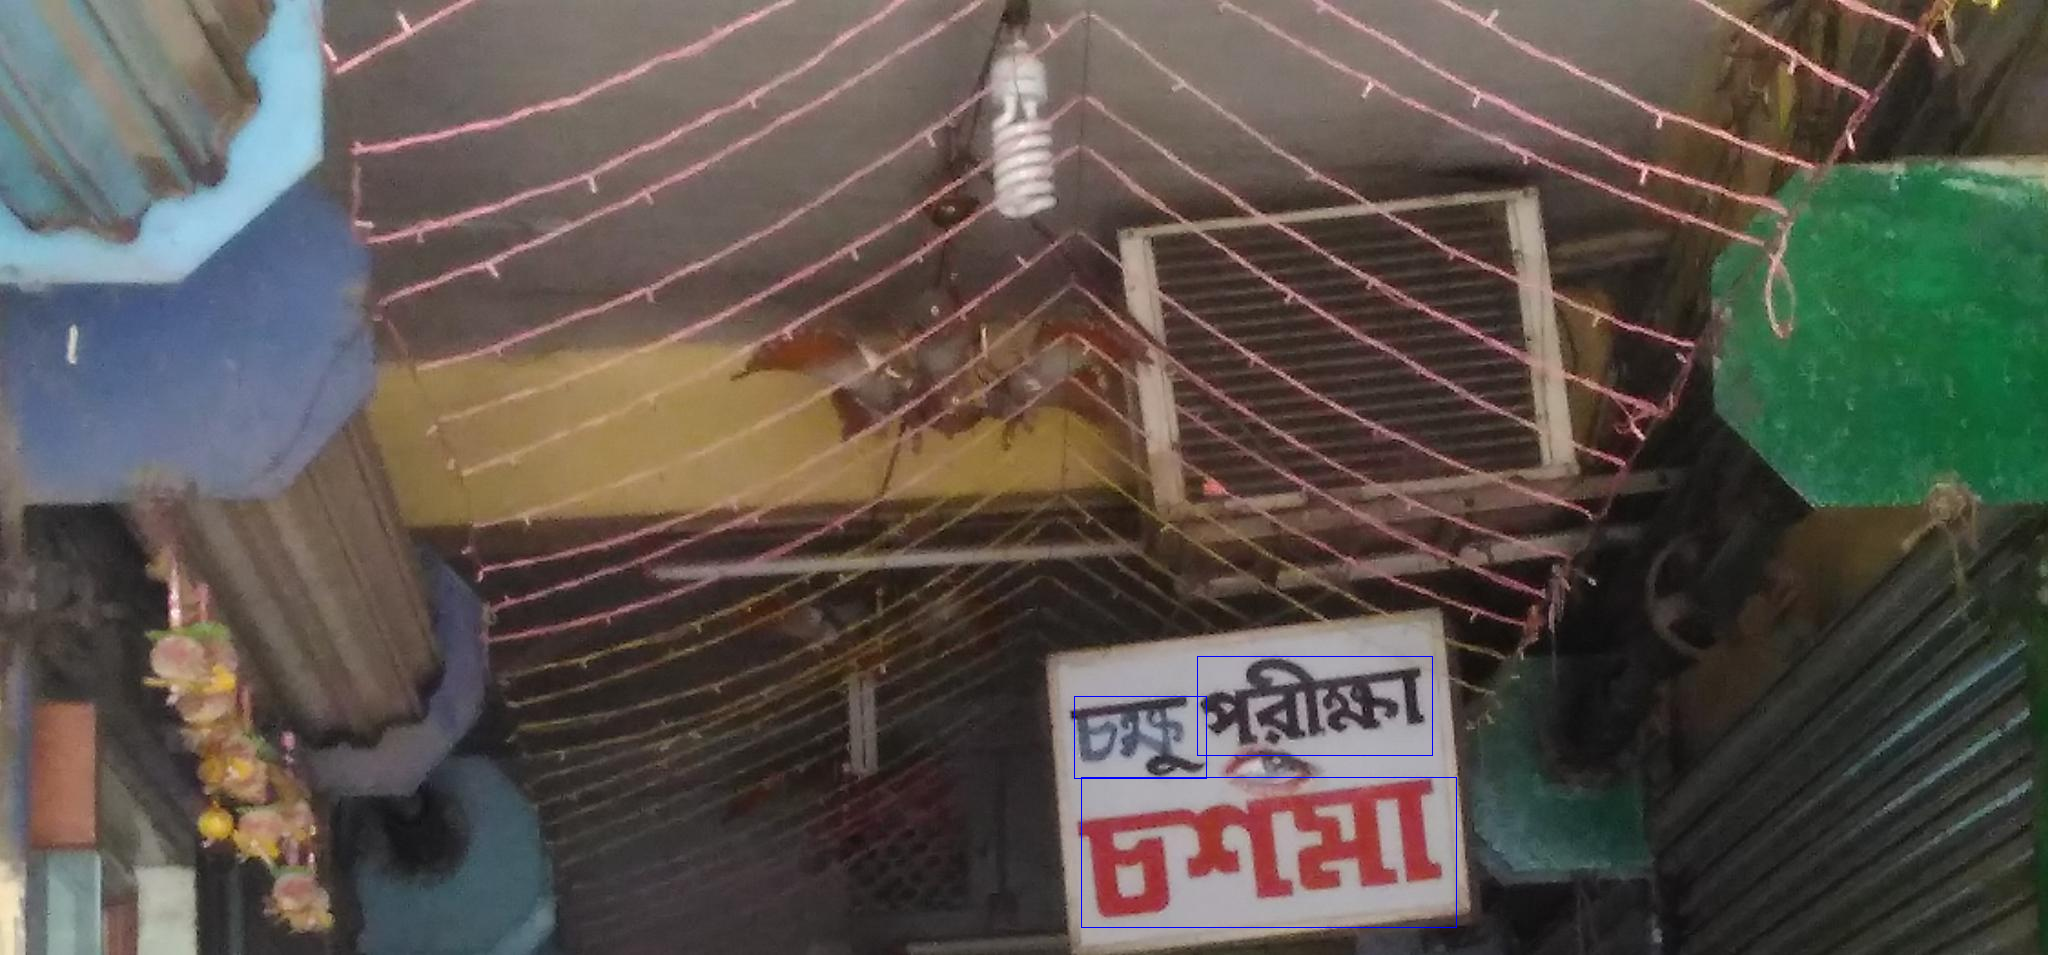

26 89
31 105
40 134


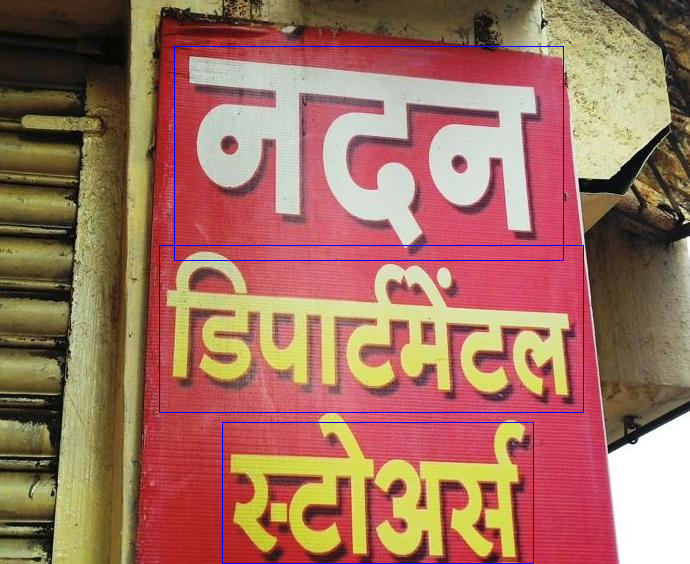

33 112


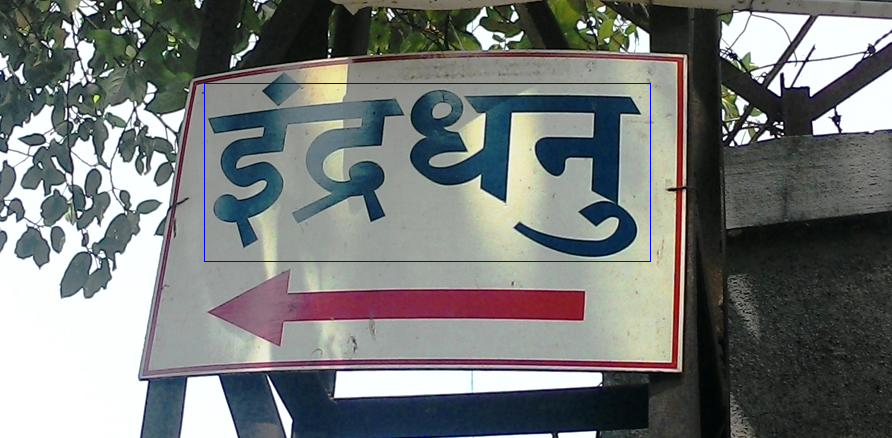

In [ ]:
def preprocess(image):

        #image=cv2.resize(image,(640,640))

        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]

        image = image.astype(np.float32)
        image /= 255.
        image -= mean
        image /= std

        

        if(image.shape[-1]==3):
            image=np.transpose(image,(2,0,1))

        return image
model.model.eval()
model.model.to("cpu")
images=os.listdir(pth+'/validate/image/')
masks=os.listdir(pth+'/validate/mask/')

for i in range(25):
  img=cv2.imread(pth+'/validate/image/'+images[i])
  
  predmap=model.model(torch.unsqueeze(torch.tensor(preprocess(img),dtype=torch.float32),0))[-1]

  
  predmap=predmap[0][0].detach().numpy()
  prediction=(predmap* 255).astype(np.uint8)
  #prediction=cv2.imread(pth+'/validate/mask/'+images[i])
 
  prediction = cv2.blur(prediction, (10,10))
  _, prediction = cv2.threshold(prediction, 50, 255,	cv2.THRESH_BINARY)
  prediction=cv2.resize(prediction,img.shape[:-1][::-1])
  contours, _ = cv2.findContours(prediction, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
  for contour in contours:
    (x,y,w,h) = cv2.boundingRect(contour)
    if (h>40):factor=int(h*0.3)
    else: factor=int(h*0.1)
    print(factor,h)
    cv2.rectangle(img, (x-factor,y-factor), (x+w+factor,y+h+factor), (255, 0, 0), 1)
  cv2_imshow(img)
  #cv2_imshow(prediction_img)
